# Packages

In [150]:
import os
import sys
import torch
import numpy as np      
from netCDF4 import Dataset  
from scipy.ndimage import label
from skimage.transform import resize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
sys.path.insert(1, "/home/users/mendrika/SSA/SA/module")
import snflics

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np

# These are specific to Zambia

In [151]:
y_min, y_max = 1403, 1914
x_min, x_max = 66, 577

# Crop geo coordinates

In [152]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][y_min:y_max+1, x_min:x_max+1]
lats = geodata["lat"][y_min:y_max+1, x_min:x_max+1]

# Choose a file

In [153]:
data_path = "/work/scratch-nopw2/mendrika/OB/raw"

In [154]:
year = "2020"
month = "07"
day = "14"
hour = "22"
minute = "00"

In [155]:
t_0 = f"{year}{month}{day}_{hour}{minute}.pt"

lead_time = 0

In [156]:
input_filename = f"{data_path}/inputs_t0/input-{t_0}"

output_filename = f"{data_path}/targets_t{lead_time}/target-{t_0}"

In [157]:
input_data = torch.load(input_filename)["input_tensor"]
input_time = torch.load(input_filename)["nowcast_origin"]

In [158]:
output_data = torch.load(output_filename)["data"].numpy()

In [159]:
output_data.shape

(512, 512)

# Number of observed cores at time $t_0$

In [160]:
lags = [120, 90, 60, 30, 0]
for i, lag in enumerate(lags):
    n_real = torch.sum(input_data[i, :, :][:,-1]==1).item()
    print(f"Time lag {lag:>3} min → {n_real:2d} real cores, {50 - n_real:2d} padded")

Time lag 120 min → 10 real cores, 40 padded
Time lag  90 min →  6 real cores, 44 padded
Time lag  60 min →  5 real cores, 45 padded
Time lag  30 min →  6 real cores, 44 padded
Time lag   0 min →  5 real cores, 45 padded


In [161]:
# Extract block for lag 0
block = input_data[-1, :, :]

# Select only real (non-padded) cores
real_mask = block[:, -1] == 1
real_cores = block[real_mask]

# Extract features
month_sin = real_cores[:, 0].numpy() 
month_cos = real_cores[:, 1].numpy()
tod_sin = real_cores[:, 2].numpy()
tod_cos = real_cores[:, 3].numpy()
x0_lats  = real_cores[:, 4].numpy()
x0_lons  = real_cores[:, 5].numpy()
lat_mins = real_cores[:, 6].numpy()
lat_maxs = real_cores[:, 7].numpy()
lon_mins = real_cores[:, 8].numpy()
lon_maxs = real_cores[:, 9].numpy()

In [162]:
month_angle = 2 * np.pi * (int(month) - 1) / 12.0
tod_angle = 2 * np.pi * (int(hour) + int(minute) / 60.0) / 24.0

In [163]:
print(np.sin(tod_angle), np.cos(tod_angle))

-0.5000000000000004 0.8660254037844384


In [164]:
print(tod_sin[0], tod_cos[0])

-0.5 0.8660254


# Plot target

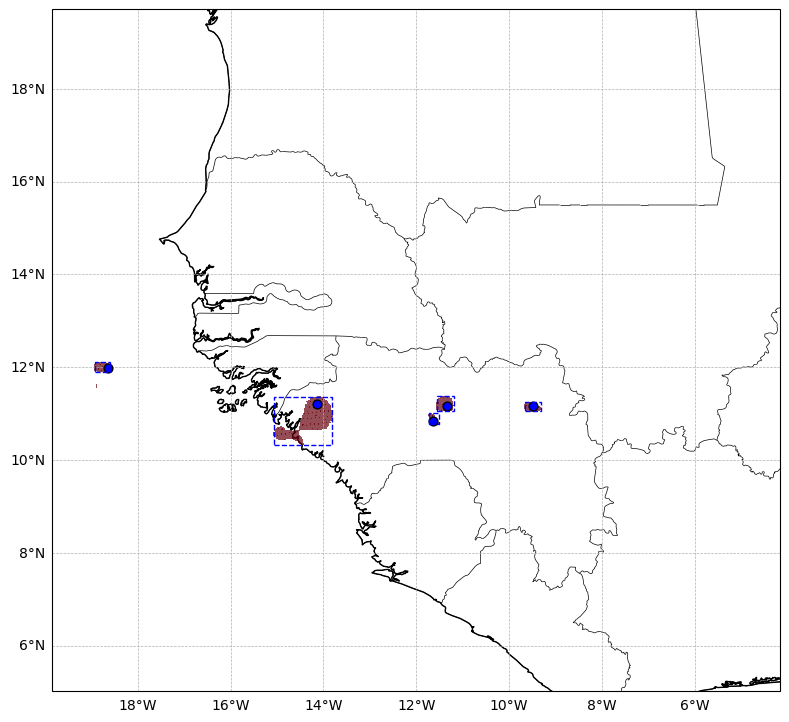

In [165]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

western_sahel_lat_min = 5.1
western_sahel_lat_max = 19.5
western_sahel_lon_min = -18.5  
western_sahel_lon_max = -4.45

extent = (
    western_sahel_lon_min,
    western_sahel_lon_max,
    western_sahel_lat_min,
    western_sahel_lat_max,
)

# Base features
ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='none', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m', category='cultural', name=shapename)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=1, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False

# --- Plot the binary storm core mask ---
masked_output = np.ma.masked_where(output_data == 0, output_data)

contour_core = ax.pcolormesh(
    lons, lats, masked_output,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.Reds,
    vmin=0, vmax=1,
    alpha=0.7,
    zorder=2
)

# --- Scatter real cores (lag 0) ---
ax.scatter(
    x0_lons, x0_lats,
    s=40, color="blue", edgecolor="black",
    transform=ccrs.PlateCarree(),
    label="Lag 0 real cores", zorder=3
)

# --- Draw rectangles for each core extent ---
from matplotlib.patches import Rectangle

for lon_min, lon_max, lat_min, lat_max in zip(lon_mins, lon_maxs, lat_mins, lat_maxs):
    width = lon_max - lon_min
    height = lat_max - lat_min
    rect = Rectangle(
        (lon_min, lat_min),
        width,
        height,
        linewidth=1,
        edgecolor="blue",
        facecolor="none",
        linestyle="--",
        transform=ccrs.PlateCarree(),
        zorder=4
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()


In [166]:
from scipy.ndimage import label

In [167]:
labeled_array, _ = label(output_data != 0)
core_labels = np.unique(labeled_array[labeled_array != 0])

In [168]:
len(core_labels)

6

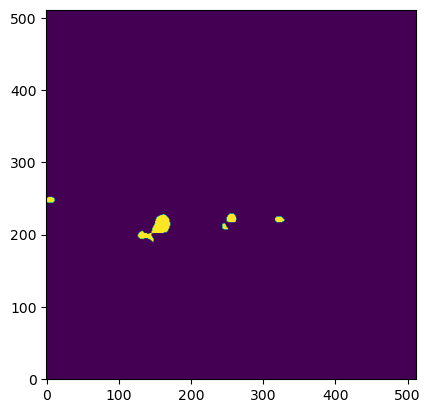

In [169]:
plt.imshow(output_data, origin='lower')
plt.show()